<div style="background-color:#7B241C; color:#F1C40F; font-size:40px;text-align: center; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Deep Convolutionnal Generative Adversarial Network (DCGAN) </div><div style="background-color:#C0392B; text-align: center;color:#19180F; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
 DL Lecture with Pr. Kelly Joly  <br>  By :   <span style="color:#F1C40F">Salah EL HABACHI</span>  &  <span style="color:#F1C40F"> Christian LOMBARDO-VIDAL</span>
 
 </div>
<div style="background-color:#D98880; color:#19180F; text-align: center;font-size:30px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Introduction & Motivation </div>
<div style="background-color:#D5D9F2; color:#19180F; font-size:20px; font-family:verdana; padding:10px; border: 5px solid #19180F; border-radius:10px "> 
In this notebook we are going to present our DCGAN. Its purpose is to generate
fake images that look like real images, after training on a particular dataset. 
We were interested in GANs because we  thought it would be really interesting to 
dive into the details of training one. For other types of deep learning 
architectures, it can be pretty straightforward to train a network, but that is 
not the case with GANs.
</div>



<div style="background-color:#D5D9F2; color:#19180F; font-size:20px; font-family:verdana; padding:10px; border: 5px solid #19180F; border-radius:10px "> 
Our training was executed on NVIDIA's last generation GPUs, `A100`. because on CPU this took more then 5 hours, And this is for `128x128` images.
We will discuss about scaling up our GAN later.  
</div>




<div style="background-color:#F1C40F; color:#C0392B; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> I. Libraries, Data Loader and Dataset </div>
<div style="background-color:#D5D9F2; color:#19180F; font-size:20px; font-family:verdana; padding:10px; border: 5px solid #19180F; border-radius:10px "> 
The first part of the project was to be able to load correctly our datasets. For
this, we used the different utility classes of PyTorch such as `Dataset` and
The first part of my project was to be able to load my datasets correctly. For this, I used the different utility classes of PyTorch such as `Dataset` and `DataLoader` from `torch.utils.data`. With these classes, I just had to implement some methods to retrieve an item from the dataset and to get the total length of the dataset, and I could use the whole system behind it. For example, it was possible to use this machinery to do shuffling, multiprocess loading, batch prefetching, dataset weighting, and much more.

Moreover, I used different image transforms from `torchvision.transform`, such as resizing, cropping, horizontal flipping, or transforms composition, for example. It was really useful to use this kind of transformations for data augmentation. Hence, the images from the dataset are not always exactly the same, making it harder for the network to overfit on the training set.
</div>


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Importing modules
    </div>

In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm import tqdm
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
from torchviz import make_dot
from torchvision import models
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import warnings
warnings.simplefilter('ignore')

warnings.filterwarnings("ignore", category=UserWarning, message=".*?libpng.*?")

%matplotlib inline

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Functions for loading and preparing data   </div>

In [3]:
def load_data(data_dir, image_size=64, batch_size=128):
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    
    train_ds = ImageFolder(data_dir, transform=T.Compose([T.Resize(image_size),
                                                T.CenterCrop(image_size),
                                                T.ToTensor(),
                                                T.Normalize(*stats)]))
    
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=False)
    
    return train_dl

In [4]:
# Assigns the data directory path to the variable data_dir
data_dir = 'images/pokemon'

In [5]:
# Loads the dataset using the load_data function and the data directory path
train_dl = load_data(data_dir)

In [6]:
# Prints the image files in the data folder
print(os.listdir(data_dir))

['pokemon']


In [7]:
# Imprime os primeiros 10 arquivos de imagem na subpasta "pokemon_jpg"
print(os.listdir(os.path.join(data_dir, 'pokemon'))[:10])

['1.png', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png']


In [8]:
# Define some variables for the dataset
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images,nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_xticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0).cpu().numpy())

In [11]:
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break



<div style="background-color:#D5D9F2; color:#19180F; font-size:20px; font-family:verdana; padding:10px; border: 5px solid #19180F; border-radius:10px "> 
Using batches in deep learning optimizes computational efficiency by reducing the processing cost of data into smaller batches, thereby facilitating model training on large datasets. For instance, a batch size of 64 is commonly used in practice. 
</div>




<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Show a batch example    </div>

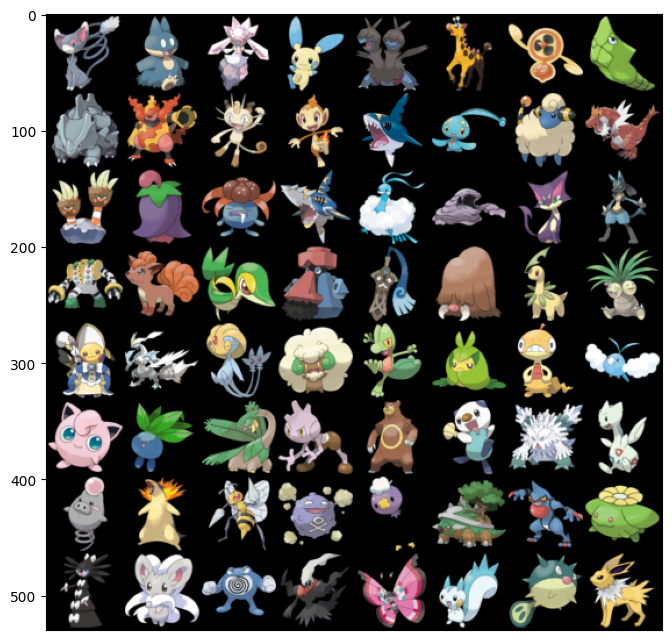

In [12]:
show_batch(train_dl)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Computation on GPU ( if available )  </div>

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda:1')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [14]:
device = get_default_device()

In [15]:
#Load the dataset onto the GPU (if available)
train_dl = load_data(data_dir)
train_dl = DeviceDataLoader(train_dl, device)

<div style="background-color:#F1C40F; color:#C0392B; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> II. Model </div>
<div style="background-color:#D5D9F2; color:#19180F; font-size:20px; font-family:verdana; padding:10px; border: 5px solid #19180F; border-radius:10px "> 
The first part of the project was to be able to load correctly our datasets. For
this, we used the different utility classes of PyTorch such as `Dataset` and
The first part of my project was to be able to load my datasets correctly. For this, I used the different utility classes of PyTorch such as `Dataset` and `DataLoader` from `torch.utils.data`. With these classes, I just had to implement some methods to retrieve an item from the dataset and to get the total length of the dataset, and I could use the whole system behind it. For example, it was possible to use this machinery to do shuffling, multiprocess loading, batch prefetching, dataset weighting, and much more.

Moreover, we used different image transforms from `torchvision.transform`, such as resizing, cropping, horizontal flipping, or transforms composition, for example. It was really useful to use this kind of transformations for data augmentation. Hence, the images from the dataset are not always exactly the same, making it harder for the network to overfit on the training set.
</div>


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Discriminator Class   </div>

<div style="background-color:#D5D9F2; color:#19180F; font-size:20px; font-family:verdana; padding:10px; border: 5px solid #19180F; border-radius:10px "> 
One of the reasons for my choice of PyTorch is that it allows inheritance from the Module class, making it flexible. In my case, I inherited from this class to customize the construction of my discriminator neural network.
</div>

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.lrelu1 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.lrelu2 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.lrelu3 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)
        self.lrelu4 = nn.LeakyReLU(0.2, inplace=True)
        
        self.fc1 = nn.Linear(512*4*4, 512)
        self.lrelu5 = nn.LeakyReLU(0.2, inplace=True)
        
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.lrelu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.lrelu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.lrelu3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.lrelu4(x)
        
        x = x.view(-1, 512*4*4)
        x = self.fc1(x)
        x = self.lrelu5(x)
        
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [17]:
discriminator = Discriminator().to(device)

In [18]:
from torchsummary import summary
summary(Discriminator(), input_size=(3, 64, 64),device='cpu')  # Input size est la taille de l'entrée (channels, height, width)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Linear-13                  [-1, 512]       4,194,816
        LeakyReLU-14                  [

<div style="background-color:#D5D9F2; color:#19180F; font-size:20px; font-family:verdana; padding:10px; border: 5px solid #19180F; border-radius:10px "> 
This discriminator architecture utilizes Conv2d layers to extract features from input images, helping to capture both local and global information. Batch Normalization layers stabilize and accelerate training by normalizing the input to each layer. Leaky ReLU activation functions introduce non-linearity while avoiding the vanishing gradient problem. The progressively increasing number of output channels in convolutional layers allows for hierarchical feature representation. Fully connected layers at the end serve to further process the extracted features for classification. Leaky ReLU activation before the last fully connected layer helps maintain the non-linear properties of the network. Finally, the Sigmoid activation in the last layer outputs a probability indicating the likelihood of the input image being real. This architecture with <span style="color:red">6 952 833</span> parameters is designed for discriminating between real and generated images in adversarial learning scenarios..
</div>

<div style="background-color:#D5D9F2; color:#19180F; font-size:20px; font-family:verdana; padding:10px; border: 5px solid #19180F; border-radius:10px "> 
In GANs, the size of the latent space significantly affects the quality and variety of generated outputs. For Pokémon generation, a latent space size of 128 has been chosen as it strikes a balance between expressiveness and computational efficiency. This size allows the model to capture diverse Pokémon characteristics while remaining computationally feasible.
</div>

In [19]:
latent_size = 128

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Generator Class   </div>

In [20]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(256*2, 128*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(128*4, 64*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        x = self.main(z)
        return x


In [21]:
generator = Generator(latent_size=128).to(device)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Generator Arrchitecture   </div>

In [22]:
from torchsummary import summary
summary(Generator(latent_size=latent_size), (128, 1, 1),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       4,194,304
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 512, 16, 16]       4,194,304
       BatchNorm2d-8          [-1, 512, 16, 16]           1,024
              ReLU-9          [-1, 512, 16, 16]               0
  ConvTranspose2d-10          [-1, 512, 32, 32]       4,194,304
      BatchNorm2d-11          [-1, 512, 32, 32]           1,024
             ReLU-12          [-1, 512, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]          24,576
             Tanh-14            [-1, 3,

<div style="background-color:#D5D9F2; color:#19180F; font-size:20px; font-family:verdana; padding:10px; border: 5px solid #19180F; border-radius:10px "> 
The generator architecture above employs a series of transposed convolutional layers followed by batch normalization and ReLU activation functions. This design choice aims to gradually upsample the input latent vectors to match the desired output image dimensions of 64x64 pixels with 3 RGB channels. 

The first ConvTranspose2d layer with an output shape of [-1, 512, 4, 4] helps initialize the generation process by creating a low-resolution feature map. The subsequent layers progressively increase the spatial dimensions, allowing the network to capture more intricate features and details.

Batch normalization is utilized after each convolutional layer to stabilize and accelerate the training process. It normalizes the input of each layer, ensuring that activations remain within a reasonable range and preventing the issues associated with internal covariate shift.

ReLU activation functions are employed to introduce non-linearity into the network, enabling the generator to learn complex mappings from the latent space to the image space. ReLU helps alleviate the vanishing gradient problem and facilitates faster convergence during training.

The final ConvTranspose2d layer outputs the generated image with dimensions [-1, 3, 64, 64], followed by a Tanh activation function to scale the pixel values to the range [-1, 1], making them suitable for image display. This architecture, with its progressive upsampling and regularization techniques, enables the generator to learn diverse and realistic Pokémon images from random latent vectors.
</div>

In [23]:
# Define the device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Send generator to the GPU (if available)
generator.to(device)

# Generate fake images from the latent tensor on the GPU (if available)
        # Just to initialize the Generator 
latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_images = generator(latent)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Choice of Loass Function   </div>

<div style="background-color:#D5D9F2; color:#19180F; font-size:20px; font-family:verdana; padding:10px; border: 5px solid #19180F; border-radius:10px "> 
The BCELoss (Binary Cross Entropy Loss) function is commonly used in GANs (Generative Adversarial Networks) due to its relevance to the binary discrimination task. This loss function is well-suited because it measures the divergence between the probability distributions of real and generated data. In a GAN, the generator aims to produce data that is indistinguishable from real data, while the discriminator aims to distinguish between them. By minimizing BCELoss, the generator learns to produce more realistic data, while the discriminator learns to better discriminate them. This results in an adversarial learning process that progressively improves the generator's ability to produce realistic data. Hence, BCELoss is a prudent choice for GANs because of its capacity to promote this competition between the generator and discriminator, leading to an enhancement in the quality of generated data.
</div>

In [24]:
# Instantiate the loss function
criterion = nn.BCELoss()

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Discriminator & Generator Trainig   </div>

<div style="background-color:#D5D9F2; color:#19180F; font-size:20px; font-family:verdana; padding:10px; border: 5px solid #19180F; border-radius:10px "> 
GANs are trained in the following fashion : In each training loops, we sample
first a batch of points from the latent space, that we feed to the generator
that outputs a batch of fake images. We feed them to the discriminator, that
has to label them as real or fake. Obviously, its goal is to label the
generator images as fake. We then feed a batch of images from the dataset to
the discriminator, that has to label them aswell. Once the training step of the
discriminator is finished, we train the generator. After sampling a batch of
latent points and feeding them to the generator, we freeze the discriminator
weights and ask it to label the fake images. Here, the goal of the generator is
to have its images labeled as real, and we compute the loss accordingly.

The following [diagram](https://developers.google.com/machine-learning/gan/discriminator) 
summarize this process : 

<img src="fig/google_diagram.svg" alt="Training of a GAN" width="700"/>

There are different variants of how we execute this training, and different ways
to tweak the training. For example we can :
- Train k times the discriminator and only once the generator (k is typically 
low : 2 or 3)
- Use a different learning rate for each network
- Add noise the to real and generated images
- Change the latent space dimension (not trivial, the whole network
architecture needs to be able to convert it to an image)
- Perform "label smooting", by setting the label of real images to 0.9 instead
of 1 for example, in order regularize the discriminator by making it less 
overconfident of his predictions
- Tune the different hyperparameters
- Regularize the networks with L1, L2 weight decay
</div>

In [25]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [26]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Save Generated Images  </div>

In [38]:
sample_dir = 'generated_DCGAN'
os.makedirs(sample_dir, exist_ok=True)

In [68]:
def save_samples(index, latent_tensors, show=True,sample_dir=sample_dir):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Latent Space  </div>

<div style="background-color:#D5D9F2; color:#19180F; font-size:20px; font-family:verdana; padding:10px; border: 5px solid #19180F; border-radius:10px "> 
The strength of GANs lies in their ability to generate from a latent space. In my case, my latent space will be composed of normal Gaussian distributions. This is what distinguishes a GAN (which generates) from an autoencoder (which reconstructs). This difference arises from the fact that for the former, the latent spaces are distributions, whereas for the latter, the latent space is hard-coded.

In my case, I sample 64 random vectors following the distribution of the latent space each time. These vectors serve as the input to my GAN to generate 64 fake 2D images.
</div>

In [41]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
To fitt the global model : DCGAN </div>

In [42]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Treina discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Treina generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        if epoch+1%100 ==0 :
            print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

<div style="background-color:#F1C40F; color:#C0392B; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> III. Image generation  </div>



<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Hyper parameters</div>

In [44]:
# Define the training parameters
epochs = 1000
lr = 0.002

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Start training & Generating</div>

In [45]:
history = fit(epochs, lr)

  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0001.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0002.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0003.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0004.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0005.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0006.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0007.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0008.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0009.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0010.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0011.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0012.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0013.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0014.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0015.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0016.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0017.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0018.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0019.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0020.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0021.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0022.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0023.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0024.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0025.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0026.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0027.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0028.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0029.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0030.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0031.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0032.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0033.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0034.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0035.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0036.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0037.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0038.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0039.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0040.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0041.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0042.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0043.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0044.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0045.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0046.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0047.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0048.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0049.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0050.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0051.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0052.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0053.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0054.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0055.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0056.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0057.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0058.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0059.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0060.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0061.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0062.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0063.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0064.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0065.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0066.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0067.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0068.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0069.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0070.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0071.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0072.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0073.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0074.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0075.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0076.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0077.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0078.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0079.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0080.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0081.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0082.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0083.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0084.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0085.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0086.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0087.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0088.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0089.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0090.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0091.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0092.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0093.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0094.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0095.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0096.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0097.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0098.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0099.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0100.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0101.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0102.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0103.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0104.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0105.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0106.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0107.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0108.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0109.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0110.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0111.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0112.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0113.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0114.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0115.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0116.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0117.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0118.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0119.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0120.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0121.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0122.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0123.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0124.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0125.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0126.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0127.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0128.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0129.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0130.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0131.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0132.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0133.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0134.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0135.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0136.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0137.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0138.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0139.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0140.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0141.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0142.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0143.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0144.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0145.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0146.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0147.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0148.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0149.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0150.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0151.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0152.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0153.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0154.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0155.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0156.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0157.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0158.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0159.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0160.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0161.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0162.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0163.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0164.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0165.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0166.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0167.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0168.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0169.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0170.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0171.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0172.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0173.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0174.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0175.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0176.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0177.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0178.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0179.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0180.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0181.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0182.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0183.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0184.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0185.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0186.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0187.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0188.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0189.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0190.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0191.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0192.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0193.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0194.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0195.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0196.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0197.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0198.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0199.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0200.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0201.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0202.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0203.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0204.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0205.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0206.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0207.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0208.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0209.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0210.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0211.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0212.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0213.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0214.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0215.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0216.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0217.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0218.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0219.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0220.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0221.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0222.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0223.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0224.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0225.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0226.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0227.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0228.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0229.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0230.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0231.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0232.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0233.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0234.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0235.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0236.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0237.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0238.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0239.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0240.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0241.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0242.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0243.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0244.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0245.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0246.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0247.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0248.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0249.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0250.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0251.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0252.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0253.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0254.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0255.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0256.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0257.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0258.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0259.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0260.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0261.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0262.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0263.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0264.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0265.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0266.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0267.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0268.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0269.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0270.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0271.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0272.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0273.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0274.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0275.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0276.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0277.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0278.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0279.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0280.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0281.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0282.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0283.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0284.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0285.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0286.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0287.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0288.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0289.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0290.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0291.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0292.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0293.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0294.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0295.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0296.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0297.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0298.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0299.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0300.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0301.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0302.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0303.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0304.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0305.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0306.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0307.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0308.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0309.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0310.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0311.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0312.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0313.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0314.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0315.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0316.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0317.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0318.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0319.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0320.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0321.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0322.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0323.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0324.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0325.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0326.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0327.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0328.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0329.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0330.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0331.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0332.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0333.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0334.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0335.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0336.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0337.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0338.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0339.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0340.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0341.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0342.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0343.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0344.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0345.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0346.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0347.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0348.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0349.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0350.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0351.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0352.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0353.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0354.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0355.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0356.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0357.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0358.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0359.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0360.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0361.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0362.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0363.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0364.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0365.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0366.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0367.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0368.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0369.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0370.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0371.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0372.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0373.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0374.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0375.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0376.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0377.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0378.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0379.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0380.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0381.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0382.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0383.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0384.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0385.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0386.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0387.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0388.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0389.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0390.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0391.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0392.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0393.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0394.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0395.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0396.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0397.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0398.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0399.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0400.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0401.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0402.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0403.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0404.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0405.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0406.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0407.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0408.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0409.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0410.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0411.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0412.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0413.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0414.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0415.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0416.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0417.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0418.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0419.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0420.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0421.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0422.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0423.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0424.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0425.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0426.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0427.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0428.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0429.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0430.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0431.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0432.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0433.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0434.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0435.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0436.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0437.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0438.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0439.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0440.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0441.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0442.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0443.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0444.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0445.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0446.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0447.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0448.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0449.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0450.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0451.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0452.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0453.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0454.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0455.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0456.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0457.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0458.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0459.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0460.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0461.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0462.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0463.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0464.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0465.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0466.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0467.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0468.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0469.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0470.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0471.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0472.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0473.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0474.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0475.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0476.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0477.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0478.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0479.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0480.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0481.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0482.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0483.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0484.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0485.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0486.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0487.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0488.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0489.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0490.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0491.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0492.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0493.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0494.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0495.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0496.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0497.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0498.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0499.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0500.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0501.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0502.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0503.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0504.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0505.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0506.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0507.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0508.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0509.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0510.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0511.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0512.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0513.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0514.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0515.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0516.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0517.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0518.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0519.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0520.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0521.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0522.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0523.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0524.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0525.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0526.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0527.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0528.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0529.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0530.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0531.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0532.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0533.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0534.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0535.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0536.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0537.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0538.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0539.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0540.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0541.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0542.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0543.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0544.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0545.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0546.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0547.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0548.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0549.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0550.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0551.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0552.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0553.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0554.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0555.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0556.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0557.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0558.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0559.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0560.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0561.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0562.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0563.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0564.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0565.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0566.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0567.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0568.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0569.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0570.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0571.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0572.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0573.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0574.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0575.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0576.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0577.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0578.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0579.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0580.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0581.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0582.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0583.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0584.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0585.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0586.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0587.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0588.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0589.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0590.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0591.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0592.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0593.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0594.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0595.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0596.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0597.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0598.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0599.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0600.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0601.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0602.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0603.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0604.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0605.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0606.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0607.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0608.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0609.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0610.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0611.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0612.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0613.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0614.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0615.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0616.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0617.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0618.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0619.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0620.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0621.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0622.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0623.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0624.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0625.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0626.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0627.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0628.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0629.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0630.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0631.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0632.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0633.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0634.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0635.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0636.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0637.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0638.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0639.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0640.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0641.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0642.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0643.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0644.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0645.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0646.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0647.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0648.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0649.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0650.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0651.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0652.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0653.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0654.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0655.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0656.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0657.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0658.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0659.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0660.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0661.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0662.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0663.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0664.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0665.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0666.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0667.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0668.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0669.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0670.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0671.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0672.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0673.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0674.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0675.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0676.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0677.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0678.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0679.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0680.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0681.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0682.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0683.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0684.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0685.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0686.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0687.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0688.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0689.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0690.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0691.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0692.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0693.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0694.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0695.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0696.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0697.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0698.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0699.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0700.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0701.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0702.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0703.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0704.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0705.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0706.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0707.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0708.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0709.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0710.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0711.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0712.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0713.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0714.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0715.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0716.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0717.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0718.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0719.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0720.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0721.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0722.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0723.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0724.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0725.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0726.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0727.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0728.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0729.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0730.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0731.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0732.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0733.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0734.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0735.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0736.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0737.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0738.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0739.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0740.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0741.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0742.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0743.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0744.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0745.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0746.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0747.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0748.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0749.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0750.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0751.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0752.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0753.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0754.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0755.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0756.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0757.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0758.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0759.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0760.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0761.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0762.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0763.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0764.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0765.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0766.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0767.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0768.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0769.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0770.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0771.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0772.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0773.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0774.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0775.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0776.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0777.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0778.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0779.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0780.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0781.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0782.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0783.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0784.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0785.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0786.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0787.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0788.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0789.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0790.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0791.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0792.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0793.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0794.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0795.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0796.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0797.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0798.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0799.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0800.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0801.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0802.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0803.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0804.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0805.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0806.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0807.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0808.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0809.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0810.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0811.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0812.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0813.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0814.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0815.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0816.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0817.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0818.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0819.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0820.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0821.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0822.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0823.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0824.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0825.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0826.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0827.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0828.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0829.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0830.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0831.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0832.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0833.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0834.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0835.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0836.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0837.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0838.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0839.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0840.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0841.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0842.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0843.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0844.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0845.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0846.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0847.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0848.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0849.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0850.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0851.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0852.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0853.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0854.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0855.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0856.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0857.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0858.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0859.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0860.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0861.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0862.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0863.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0864.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0865.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0866.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0867.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0868.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0869.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0870.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0871.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0872.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0873.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0874.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0875.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0876.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0877.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0878.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0879.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0880.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0881.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0882.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0883.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0884.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0885.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0886.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0887.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0888.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0889.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0890.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0891.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0892.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0893.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0894.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0895.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0896.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0897.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0898.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0899.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0900.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0901.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0902.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0903.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0904.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0905.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0906.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0907.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0908.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0909.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0910.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0911.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0912.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0913.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0914.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0915.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0916.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0917.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0918.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0919.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0920.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0921.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0922.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0923.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0924.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0925.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0926.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0927.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0928.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0929.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0930.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0931.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0932.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0933.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0934.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0935.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0936.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0937.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0938.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0939.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0940.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0941.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0942.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0943.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0944.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0945.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0946.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0947.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0948.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0949.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0950.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0951.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0952.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0953.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0954.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0955.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0956.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0957.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0958.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0959.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0960.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0961.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0962.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0963.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0964.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0965.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0966.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0967.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0968.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0969.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0970.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0971.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0972.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0973.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0974.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0975.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0976.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0977.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0978.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0979.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0980.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0981.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0982.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0983.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0984.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0985.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0986.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0987.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0988.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0989.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0990.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0991.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0992.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0993.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0994.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0995.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0996.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0997.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0998.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-0999.png


  0%|          | 0/7 [00:00<?, ?it/s]

Saving generated-images-1000.png


In [46]:
losses_g, losses_d, real_scores, fake_scores = history

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Look at scores over training </div>

Text(0.5, 1.0, 'Scores')

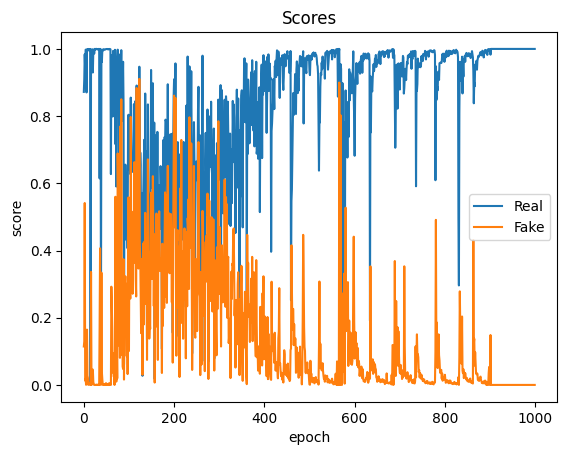

In [47]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Start training & Generating</div>

Text(0.5, 1.0, 'Losses')

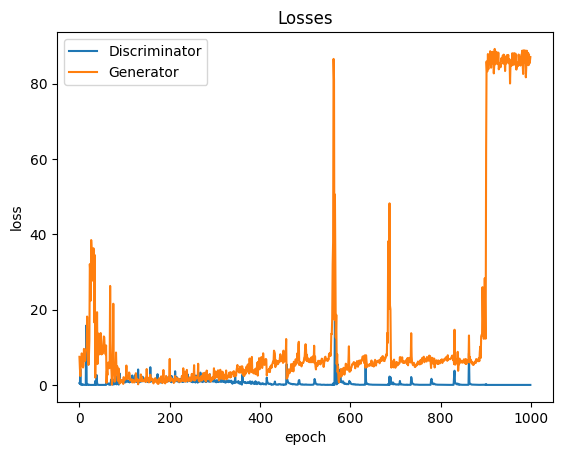

In [48]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [49]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

<img src="./Generated_animation/animation_DCGAN.gif" alt="Image centrée" style="display: block; margin-left: auto; margin-right: auto;">


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 

It's pretty obvious that the learning was fast but not that stable. This can probably be solved with <span style = "color:red">Wasserstein GANs.</span> We'll try to do it the next notebook.</div>

<div style="background-color:#7B241C; color:#F1C40F; font-size:40px;text-align: center; font-family:Arial; padding:10px; border: 5px solid #F1C40F; border-radius:10px"> Wasserstein GANs (WGAN) </div>

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 

Wasserstein Generative Adversarial Networks (WGANs) offer significant advantages over traditional Deep Convolutional GANs (DCGANs), particularly in terms of stability during training. The introduction of the Wasserstein distance metric in WGANs addresses issues such as mode collapse and vanishing gradients commonly encountered in DCGANs, resulting in more stable training dynamics. Additionally, the paper <a href="https://arxiv.org/abs/1704.00028">Improved Training of Wasserstein GANs</a> proposed a method to further stabilize training by penalizing the norm of the gradient of the critic with respect to its input, replacing the problematic weight clipping technique. This innovation contributes to more consistent convergence and higher-quality generated samples. In the subsequent code within this notebook, we implement WGANs incorporating this improvement based on the paper by Gulrajani et al. <a href="https://arxiv.org/abs/1704.00028"> [1] </a>





 <span style="color:red">Before WGAN-GP, We need to look at WGAN</span> 
 <br><br>
<div style="text-align: center;">
    <img src="https://miro.medium.com/max/1400/0*8vrccqYn7U-uIba1.png" width="500">
</div>


We have a "$\text{while }\theta\text{ has not converged}$", because, in WGAN, we were proposed with a metric for the discriminator/critic to know if it was converging or not.

- We also train the critic more than the generator. 
    - we train the critic $n_{\text{critic}}$ times before we train the generator once.
   
__Before, we get into the implementation__:

- We first, need to know that there is no sigmoid layer in the discriminator, so the values will lie from $-\infty \text{ to } \infty$.
- If we pass the real images to the critic, we expect to get a positive value, and for a fake image, we expect to get a negative value.
    - Essentially, what we want now is to maximise it because, we want to make $\mathbb{E}_{x\sim\mathbb{P}_\theta}[f(x)]$ to be as negative as possible, since we know they are fake.
        - Thus, the addition in the gradient of the critic, instead of the standard subtraction.
- For the generator, we want the real image to have a high value as well the fake images to have a high value from the critic. So, we want to minimise it for the generator.
---

### But, Why WGAN-GP?

#### As per WGAN (Wasserstein GAN)
$$\underset{\lVert f \rVert_L\le1}{\operatorname{\max}}\mathbb{E}_{x\sim\mathbb{P}_r}[f(x)]-\mathbb{E}_{x\sim\mathbb{P}_\theta}[f(x)]$$

- __Discriminator__ wants to separate, these as much as possible (_maximise_).
- __Generator__ wants to put these closer to each other (_minimise_).


- $P_r$ - Distribution of the real images (or just the real image)
- $P_\theta$ - Distribution of the fake images (or just the generator images)

WGAN presented us with a loss function which would actually converge (While maintaing the Lipschitz Inequality, that the norm of the weights is less than or equal to 1.

But, WGAN uses weight clipping, which doesn't really solve the inequality. Hence, we use WGAN-GP.

#### Improved WGAN: WGAN-GP (Wasserstein GAN with Gradient Penalty)

<div style="text-align: center;">
    <img src="https://miro.medium.com/max/1400/1*JnBQNCOJxa8w9YMc5YjoXQ.png" width="500">
</div>

- We use the `Adam` optimizer, with $\beta_1 = 0$, which essentially removes the __momentum__ term from the optimizer.
- $\tilde{x}$ is the output from the generator.
    - $\hat{x}$ is the linear combination (interpolation) of the real images and the generated image denoted as $\hat{x}=\epsilon x + (1-\epsilon)\tilde{x}$
        - The reason why do is because, there is some evidence pointed out in the paper which proves that the "Lipschitz" Inequality will be satisfied by the the data.
            - If the norm is 1 for all interpolations then: "Lipschitz Inequality" is satisfied.
- They redefine the loss as: 
$$L \leftarrow D_w(\tilde{x})-D_w(x)+\lambda(\lVert \nabla_{\tilde{x}}D_w(\tilde{x})\rVert_2-1)^2$$

</div>

<div style="background-color:#F1C40F; color:#C0392B; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> I. Discriminator  </div>



<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
The "Discriminator" is renamed as the "Critic" in this paper.
</div>

In [55]:
class Discriminator(nn.Module):
    def __init__(self, img_channels = 1, F = 100):
        '''F: Features in disc'''
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential( # (N, C, 32, 32)
            nn.Conv2d(img_channels, F, 4, 2, 1), # (N, F, 16, 16)
            nn.LeakyReLU(0.1),
            self._make_block(F, F*2, 4, 2, 1), # (N, 2*F, 8, 8)
            self._make_block(F*2, F*4, 4, 2, 1), #(N, 4*F, 4, 4)
            self._make_block(F*4, 1, 4, 2, 0) # (N, 1, 1, 1)
        )
        
    def forward(self, x):
        return self.disc(x)
    
    def _make_block(self, in_channels, out_channels, 
                    kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, 
                      padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
The Generator
</div>

In [56]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels = 1, F = 100):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._make_block(z_dim, F*8, 4, 1, 0),
            self._make_block(F*8, F*4, 4, 2, 1),
            self._make_block(F*4, F*2, 4, 2, 1),
#             self._make_block(F*4, F*2, 4, 2, 1),
            nn.ConvTranspose2d(F*2, img_channels, 4, 2, 1),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.gen(x)
    
    def _make_block(self, in_channels, out_channels, kernel_size, 
                    stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
                               stride, padding, bias=False), 
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

<div style="background-color:#F1C40F; color:#C0392B; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> II. Validating the Models  </div>



In [57]:
def test():
    """Extracted from: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/2.%20DCGAN/model.py"""
    N, in_channels, H, W = 8, 3, 32, 32
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    print(f'Discriminator Shape: {disc(x).shape}')
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    print(f'Generator Shape: {gen(z).shape}')
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Success!")

test()

Discriminator Shape: torch.Size([8, 1, 1, 1])
Generator Shape: torch.Size([8, 3, 32, 32])
Success!


<div style="background-color:#F1C40F; color:#C0392B; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> III. Hyperparameters  </div>



In [58]:
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 1e-4
BETA = (0.9, 0.999)
BATCH_SIZE = 16
IMAGE_SIZE = 256
IMG_CHANNELS = 3
Z_DIM = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
NUM_EPOCHS = 1000     
LAMBDA = 10
N_CRITIC= 5

print(f'DEVICE: {DEVICE}')

DEVICE: cuda:1


In [59]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [60]:
gen = Generator(z_dim=Z_DIM, img_channels=IMG_CHANNELS, F=FEATURES_GEN).to(DEVICE)
disc = Discriminator(img_channels=IMG_CHANNELS, F=FEATURES_DISC).to(DEVICE)

initialize_weights(gen)
initialize_weights(disc)

test()

Discriminator Shape: torch.Size([8, 1, 1, 1])
Generator Shape: torch.Size([8, 3, 32, 32])
Success!


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
The DataLoaders
</div>

In [61]:
class PokemonDataset(torch.utils.data.Dataset):
    def __init__(self, img_path):
        super(PokemonDataset, self).__init__()
        self.img_path = img_path
        print(f'IMG_PATH: {self.img_path}')
    
    def __len__(self):
        return len(os.listdir(self.img_path))
    
    def __getitem__(self, idx):
        pth = os.listdir(self.img_path)[idx]
#         print(pth)
        img = cv2.imread(self.img_path + pth, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(32, 32), interpolation = cv2.INTER_LINEAR)
#         print(img.shape)
        img = torch.tensor(img)
        img = img.permute(2, 0, 1)
        return img/255.0, 1

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Training
</div>

In [62]:
gen = Generator(z_dim=Z_DIM, img_channels=IMG_CHANNELS, F=FEATURES_GEN).to(DEVICE)
critic = Discriminator(img_channels=IMG_CHANNELS, F=FEATURES_DISC).to(DEVICE)
initialize_weights(gen)
initialize_weights(critic)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

In [63]:
DATA_DIR = 'images/pokemon/pokemon/'

dataset = PokemonDataset(img_path=DATA_DIR)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

IMG_PATH: images/pokemon/pokemon/


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Gradient Penalty
</div>

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
The gradient_penalty function computes the gradient penalty, an important regularization term in training Generative Adversarial Networks (GANs). This penalty encourages smoothness in the critic (discriminator) network by penalizing large gradients. The function takes in the critic network, real and fake images, and optionally the device for computation. It first interpolates between real and fake images, evaluates the critic on these interpolated images, and then computes the gradient of the critic's scores with respect to the interpolated images. Finally, it calculates the gradient penalty as the mean squared difference between the L2 norm of the gradients and 1. Incorporating this penalty during training helps improve the stability and convergence of GANs.
</div>

In [64]:
def gradient_penalty(critic, real, fake, device="cpu"):
    B, C, H, W = real.shape
    EPS = torch.rand((B, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * EPS + fake * (1 - EPS)
    # Calculated critic score for interpolated images
    scores = critic.forward(interpolated_images)
    
    gradient = torch.autograd.grad(
        inputs=interpolated_images, 
        outputs=scores, 
        grad_outputs=torch.ones_like(scores),
        create_graph=True, 
        retain_graph=True
    )[0] # using [0] because returns a tuple
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    grad_penalty = torch.mean((gradient_norm - 1) ** 2)
    return grad_penalty

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Training
</div>

In [65]:
import sys
import os
import warnings

# "Redirect standard error outputs to a temporary file."
error_file = "error.log"
sys.stderr = open(error_file, 'w')


warnings.filterwarnings("ignore", category=UserWarning, message=".*?libpng.*?")


sys.stderr.close()
sys.stderr = sys.__stderr__
os.remove(error_file)


<div style="background-color:#F1C40F; color:#C0392B; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> VI. Trainig and generation  </div>



In [76]:
sample_dir2 = 'generated_WGAN'
os.makedirs(sample_dir2, exist_ok=True)
def save_wsample(index,fixed_noise,fake_im) :
        
        fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
        save_image(denorm(fake_im), os.path.join(sample_dir2, fake_fname), nrow=8)
        print('Saving', fake_fname)

In [77]:
FIXED_NOISE = torch.randn((40, Z_DIM, 1, 1)).to(DEVICE)

for epoch in tqdm(range(NUM_EPOCHS), ascii=True):
    for real, _ in loader:
        real  = real.to(DEVICE)
        
        for _ in range(N_CRITIC):
            NOISE = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(DEVICE)
            fake = gen.forward(NOISE)
            critic_real = critic.forward(real).reshape(-1)
            critic_fake = critic.forward(fake).reshape(-1)
            # Maximise this so we can use the optimizer normally
            gp = gradient_penalty(critic, real, fake, device=DEVICE)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA * gp
            opt_critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()
            
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
    
    if epoch%10 == 0:
        print(f'Epoch : {epoch}  Criitc Loss: {loss_critic.item():.3f} Generator Loss: {loss_gen:.3f}')
        pred = gen.forward(FIXED_NOISE)
        #save generated images in

        
        save_wsample(1+epoch,FIXED_NOISE,pred)


        img_grid = torchvision.utils.make_grid(pred, normalize=True)
        # plt.figure(figsize=(12, 6))
        # plt.imshow(img_grid.permute([1, 2, 0]).cpu().detach())
        # plt.show()
        print(f'\n')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch : 0  Criitc Loss: 0.774 Generator Loss: -0.221
Saving generated-images-0001.png


Epoch : 10  Criitc Loss: 0.065 Generator Loss: -0.227
Saving generated-images-0011.png


Epoch : 20  Criitc Loss: 0.969 Generator Loss: -0.209
Saving generated-images-0021.png


Epoch : 30  Criitc Loss: 0.242 Generator Loss: -0.218
Saving generated-images-0031.png


Epoch : 40  Criitc Loss: 0.163 Generator Loss: -0.209
Saving generated-images-0041.png


Epoch : 50  Criitc Loss: 0.085 Generator Loss: -0.224
Saving generated-images-0051.png


Epoch : 60  Criitc Loss: 0.040 Generator Loss: -0.205
Saving generated-images-0061.png


Epoch : 70  Criitc Loss: 1.387 Generator Loss: -0.218
Saving generated-images-0071.png


Epoch : 80  Criitc Loss: 0.089 Generator Loss: -0.231
Saving generated-images-0081.png


Epoch : 90  Criitc Loss: 0.097 Generator Loss: -0.249
Saving generated-images-0091.png


Epoch : 100  Criitc Loss: 0.842 Generator Loss: -0.252
Saving generated-images-0101.png


Epoch : 110  Criitc L

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📍  We can generate a new image from a fixed random noise using our trained generator : 
</div>

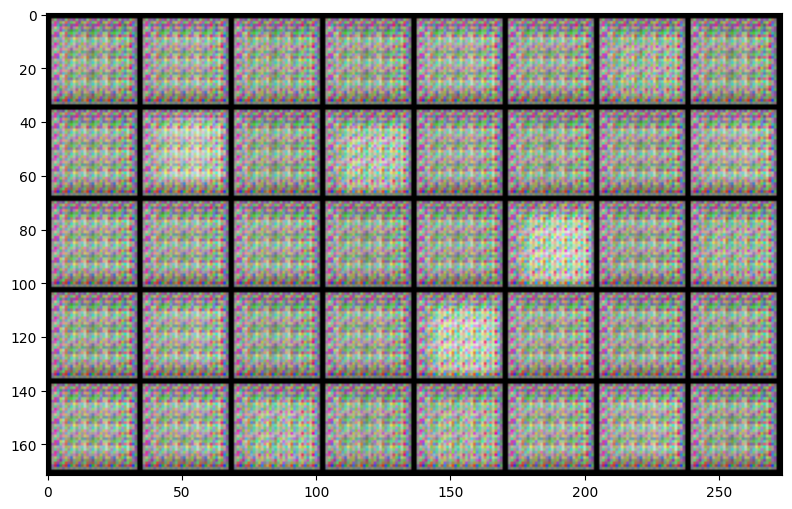

In [83]:
pred = gen.forward(FIXED_NOISE)
img_grid = torchvision.utils.make_grid(pred, normalize=True)
plt.figure(figsize=(12, 6))
plt.imshow(img_grid.permute([1, 2, 0]).cpu().detach())
plt.show()
print(f'\n')

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📍  We can observe the improvement of the generated images throughout the training process in the following animation.
</div>

<img src="./Generated_animation/animation_WGAN.gif" alt="Image centrée" style="display: block; margin-left: auto; margin-right: auto;">


<div style="background-color:#F1C40F; color:#C0392B; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> V. Conclusion and Analysis  </div>



<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
After developing two models, DCGAN and WGAN with gradient penalty, we've observed distinct behaviors in their training dynamics. DCGANs exhibit a faster learning rate compared to WGANs with gradient penalty. However, despite their quicker learning pace, DCGANs tend to suffer from instability issues during training. On the other hand, WGANs with gradient penalty demonstrate slower learning rates. In our experiments, we trained both models over 1000 epochs using the specified hyperparameters. This observation suggests that while DCGANs may learn rapidly, they struggle with stability, while WGANs with gradient penalty offer more stable training dynamics albeit at a slower pace.
</div>

<div style="background-color:#F1C40F; color:#C0392B; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> VI. Difficulties </div>



<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
During the course of this project, several challenges arose, particularly in developing models of such complexity. One significant hurdle was the computational demands imposed by training deep neural networks on GPUs. Limited GPU memory posed a constraint, requiring careful management of batch sizes and model architectures to prevent out-of-memory errors. Additionally, the extensive time required for computations, especially when training over numerous epochs, presented a logistical challenge. Moreover, selecting appropriate hyperparameters proved to be a non-trivial task, as it often involved a delicate balance between model performance and stability. Fine-tuning hyperparameters to optimize model convergence and mitigate issues such as mode collapse or vanishing gradients required iterative experimentation and thorough analysis. Overall, navigating these challenges underscored the intricate nature of developing and training sophisticated neural network architectures, demanding careful attention to computational resources, time management, and parameter tuning.
</div>